In [0]:
##Author : Kenny T Chakola
##Master's in Computer Science with Big Data 
##Simon Fraser University, Burnaby
##Created on : April 12 2020

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from pyspark.sql import SparkSession, functions, types
from pyspark.sql.functions import lit
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, mean, stddev,stddev_pop,avg,max,to_timestamp,udf,desc
from pyspark.sql import Window

In [0]:
spark = SparkSession.builder.appName('standard anomaly').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '2.4'  # make sure we have Spark 2.4+

In [0]:
input = 'Sample_test_data.csv'
# Defining the schema for tmax datasets
def sensor_schema():
    sen_schema = types.StructType([
        types.StructField('timestamp', types.StringType()),
        types.StructField('X', types.DoubleType()),
        types.StructField('Y', types.DoubleType()),
        types.StructField('Z', types.DoubleType()),
    ])
    return sen_schema

sens_schema = sensor_schema()
#Spark read of data
temp = spark.read.csv(input, schema=sens_schema)

In [0]:
temp.createOrReplaceTempView("temp")
temp = spark.sql("select timestamp,Z from temp").cache()


# Data pre-processing

In [0]:
# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),6), types.DoubleType())

assembler = VectorAssembler(
    inputCols=["Z"],
    outputCol="Zvector")
tempdata = assembler.transform(temp)
scaler = StandardScaler(inputCol="Zvector", outputCol="Zscale",withMean=True, withStd=True)
scalerModel = scaler.fit(tempdata)
scaledData = scalerModel.transform(tempdata).withColumn("Zscale", unlist("Zscale")).drop("Zvector").cache()
scaledData.show()

+--------------------+--------+---------+
|           timestamp|       Z|   Zscale|
+--------------------+--------+---------+
|2018-08-08 18:36:...|0.789063| 0.065031|
|2018-08-08 18:36:...|0.785156|-0.161642|
|2018-08-08 18:36:...| 0.78125|-0.388257|
|2018-08-08 18:36:...|0.785156|-0.161642|
|2018-08-08 18:36:...|0.789063| 0.065031|
|2018-08-08 18:36:...| 0.78125|-0.388257|
|2018-08-08 18:36:...|0.789063| 0.065031|
|2018-08-08 18:36:...|0.785156|-0.161642|
|2018-08-08 18:36:...|0.785156|-0.161642|
|2018-08-08 18:36:...| 0.78125|-0.388257|
|2018-08-08 18:36:...| 0.78125|-0.388257|
|2018-08-08 18:36:...| 0.78125|-0.388257|
|2018-08-08 18:36:...|0.789063| 0.065031|
|2018-08-08 18:36:...|0.785156|-0.161642|
|2018-08-08 18:36:...|0.785156|-0.161642|
|2018-08-08 18:36:...|0.789063| 0.065031|
|2018-08-08 18:36:...|0.789063| 0.065031|
|2018-08-08 18:36:...|0.785156|-0.161642|
|2018-08-08 18:36:...|0.785156|-0.161642|
|2018-08-08 18:36:...|0.785156|-0.161642|
+--------------------+--------+---

In [0]:
scaledData.createOrReplaceTempView("scaledData")
temp_df = spark.sql("select timestamp,Z,Zscale from scaledData").cache()

In [0]:
temp_df = temp_df.withColumn("timestamp1", to_timestamp("timestamp", 'yyyy-MM-dd HH:mm:ss')).cache()
temp_df.show()

+--------------------+--------+---------+-------------------+
|           timestamp|       Z|   Zscale|         timestamp1|
+--------------------+--------+---------+-------------------+
|2018-08-08 18:36:...|0.789063| 0.065031|2018-08-08 18:36:00|
|2018-08-08 18:36:...|0.785156|-0.161642|2018-08-08 18:36:00|
|2018-08-08 18:36:...| 0.78125|-0.388257|2018-08-08 18:36:00|
|2018-08-08 18:36:...|0.785156|-0.161642|2018-08-08 18:36:00|
|2018-08-08 18:36:...|0.789063| 0.065031|2018-08-08 18:36:00|
|2018-08-08 18:36:...| 0.78125|-0.388257|2018-08-08 18:36:00|
|2018-08-08 18:36:...|0.789063| 0.065031|2018-08-08 18:36:00|
|2018-08-08 18:36:...|0.785156|-0.161642|2018-08-08 18:36:00|
|2018-08-08 18:36:...|0.785156|-0.161642|2018-08-08 18:36:00|
|2018-08-08 18:36:...| 0.78125|-0.388257|2018-08-08 18:36:00|
|2018-08-08 18:36:...| 0.78125|-0.388257|2018-08-08 18:36:00|
|2018-08-08 18:36:...| 0.78125|-0.388257|2018-08-08 18:36:00|
|2018-08-08 18:36:...|0.789063| 0.065031|2018-08-08 18:36:00|
|2018-08

In [0]:
movAvg = temp_df.withColumn("movingAverage", avg(temp_df["Zscale"])
             .over( Window.partitionBy(temp_df["timestamp1"]).rowsBetween(-1,1))).cache()
movAvg.show()

+--------------------+--------+---------+-------------------+--------------------+
|           timestamp|       Z|   Zscale|         timestamp1|       movingAverage|
+--------------------+--------+---------+-------------------+--------------------+
|2018-08-08 18:36:...|0.792969| 0.291645|2018-08-08 18:36:55| 0.06500149999999999|
|2018-08-08 18:36:...|0.785156|-0.161642|2018-08-08 18:36:55|-0.08608466666666668|
|2018-08-08 18:36:...| 0.78125|-0.388257|2018-08-08 18:36:55|-0.08608466666666668|
|2018-08-08 18:36:...|0.792969| 0.291645|2018-08-08 18:36:55|-0.16162300000000002|
|2018-08-08 18:36:...| 0.78125|-0.388257|2018-08-08 18:36:55|-0.08608466666666668|
|2018-08-08 18:36:...|0.785156|-0.161642|2018-08-08 18:36:55|-0.08608466666666668|
|2018-08-08 18:36:...|0.792969| 0.291645|2018-08-08 18:36:55| 0.14054933333333333|
|2018-08-08 18:36:...|0.792969| 0.291645|2018-08-08 18:36:55| 0.14054933333333333|
|2018-08-08 18:36:...|0.785156|-0.161642|2018-08-08 18:36:55| 0.14054933333333333|
|201

### Normal Anomaly detection

In [0]:
mean = temp_df.groupBy().avg("Zscale").take(1)[0][0]

df_stats = temp_df.select(functions.stddev(col('Zscale')).alias('stdFull')).collect()
std = df_stats[0]['stdFull']

print(mean)
print(std)

1.730263161592889e-07
1.0000000160929277


In [0]:
temp_df = temp_df.withColumn("distance", (temp_df['Zscale']-mean)/std)
temp_df.show()

+--------------------+--------+---------+-------------------+--------------------+
|           timestamp|       Z|   Zscale|         timestamp1|            distance|
+--------------------+--------+---------+-------------------+--------------------+
|2018-08-08 18:36:...|0.789063| 0.065031|2018-08-08 18:36:00| 0.06503082592714747|
|2018-08-08 18:36:...|0.785156|-0.161642|2018-08-08 18:36:00| -0.1616421704250204|
|2018-08-08 18:36:...| 0.78125|-0.388257|2018-08-08 18:36:00|-0.38825716677812167|
|2018-08-08 18:36:...|0.785156|-0.161642|2018-08-08 18:36:00| -0.1616421704250204|
|2018-08-08 18:36:...|0.789063| 0.065031|2018-08-08 18:36:00| 0.06503082592714747|
|2018-08-08 18:36:...| 0.78125|-0.388257|2018-08-08 18:36:00|-0.38825716677812167|
|2018-08-08 18:36:...|0.789063| 0.065031|2018-08-08 18:36:00| 0.06503082592714747|
|2018-08-08 18:36:...|0.785156|-0.161642|2018-08-08 18:36:00| -0.1616421704250204|
|2018-08-08 18:36:...|0.785156|-0.161642|2018-08-08 18:36:00| -0.1616421704250204|
|201

In [0]:
temp_df.createOrReplaceTempView("anomalyData")
anomaly1_df = spark.sql("select * from anomalyData where distance > 4 or distance < -4")
anomaly1_df.show()

+--------------------+--------+---------+-------------------+-------------------+
|           timestamp|       Z|   Zscale|         timestamp1|           distance|
+--------------------+--------+---------+-------------------+-------------------+
|2018-08-08 18:36:...|0.695313|-5.374069|2018-08-08 18:36:38|-5.3740690865418115|
|2018-08-08 18:36:...|0.675781|-6.507258|2018-08-08 18:36:38| -6.507258068305482|
|2018-08-08 18:36:...|0.679688|-6.280586|2018-08-08 18:36:38| -6.280586071953298|
|2018-08-08 18:36:...|0.714844|-4.240938|2018-08-08 18:36:38|-4.2409381047772055|
|2018-08-08 18:36:...| 0.71875|-4.014323|2018-08-08 18:36:38|-4.0143231084241044|
|2018-08-08 18:36:...| 0.71875|-4.014323|2018-08-08 18:36:38|-4.0143231084241044|
|2018-08-08 18:36:...|0.859375| 4.144326|2018-08-08 18:36:43|   4.14432576027935|
|2018-08-08 18:36:...|0.871094| 4.824228|2018-08-08 18:36:43| 4.8242277493377355|
|2018-08-08 18:36:...|0.871094| 4.824228|2018-08-08 18:36:43| 4.8242277493377355|
|2018-08-08 18:3

In [0]:
anomaly1_df = anomaly1_df.withColumn("anomaly_count", functions.count(anomaly1_df["distance"])
             .over( Window.partitionBy(anomaly1_df["timestamp1"]))).cache()
final_df = anomaly1_df.select('timestamp1', 'anomaly_count').where(anomaly1_df['anomaly_count']>5).dropDuplicates().cache()
final_df = final_df.withColumnRenamed('timestamp1', 'time')
final_df = final_df.withColumnRenamed('anomaly_count', 'count')
final_df.show()

+-------------------+-----+
|               time|count|
+-------------------+-----+
|2018-08-08 18:36:58|   17|
|2018-08-08 18:36:38|    6|
+-------------------+-----+



In [0]:
target_df = temp_df.join(final_df, temp_df.timestamp1 == final_df.time, how="left").cache()
target_df = target_df.select(target_df['timestamp'],target_df['Z'],target_df['count'])
target_df = target_df.na.fill(0)
target_df.show()

+--------------------+--------+-----+
|           timestamp|       Z|count|
+--------------------+--------+-----+
|2018-08-08 18:36:...|0.789063|    0|
|2018-08-08 18:36:...|0.785156|    0|
|2018-08-08 18:36:...| 0.78125|    0|
|2018-08-08 18:36:...|0.785156|    0|
|2018-08-08 18:36:...|0.789063|    0|
|2018-08-08 18:36:...| 0.78125|    0|
|2018-08-08 18:36:...|0.789063|    0|
|2018-08-08 18:36:...|0.785156|    0|
|2018-08-08 18:36:...|0.785156|    0|
|2018-08-08 18:36:...| 0.78125|    0|
|2018-08-08 18:36:...| 0.78125|    0|
|2018-08-08 18:36:...| 0.78125|    0|
|2018-08-08 18:36:...|0.789063|    0|
|2018-08-08 18:36:...|0.785156|    0|
|2018-08-08 18:36:...|0.785156|    0|
|2018-08-08 18:36:...|0.789063|    0|
|2018-08-08 18:36:...|0.789063|    0|
|2018-08-08 18:36:...|0.785156|    0|
|2018-08-08 18:36:...|0.785156|    0|
|2018-08-08 18:36:...|0.785156|    0|
+--------------------+--------+-----+
only showing top 20 rows



In [0]:
def distlabel(count):
    label = 0
    if count > 0:
        label = 1
    return label


udf_distlabel = udf(lambda count: distlabel(count),types.IntegerType())
target_df = target_df.withColumn("anomaly", udf_distlabel("count")).cache()
target_df = target_df.drop('count')
target_df.show()

+--------------------+--------+-------+
|           timestamp|       Z|anomaly|
+--------------------+--------+-------+
|2018-08-08 18:36:...|0.789063|      0|
|2018-08-08 18:36:...|0.785156|      0|
|2018-08-08 18:36:...| 0.78125|      0|
|2018-08-08 18:36:...|0.785156|      0|
|2018-08-08 18:36:...|0.789063|      0|
|2018-08-08 18:36:...| 0.78125|      0|
|2018-08-08 18:36:...|0.789063|      0|
|2018-08-08 18:36:...|0.785156|      0|
|2018-08-08 18:36:...|0.785156|      0|
|2018-08-08 18:36:...| 0.78125|      0|
|2018-08-08 18:36:...| 0.78125|      0|
|2018-08-08 18:36:...| 0.78125|      0|
|2018-08-08 18:36:...|0.789063|      0|
|2018-08-08 18:36:...|0.785156|      0|
|2018-08-08 18:36:...|0.785156|      0|
|2018-08-08 18:36:...|0.789063|      0|
|2018-08-08 18:36:...|0.789063|      0|
|2018-08-08 18:36:...|0.785156|      0|
|2018-08-08 18:36:...|0.785156|      0|
|2018-08-08 18:36:...|0.785156|      0|
+--------------------+--------+-------+
only showing top 20 rows



In [0]:
target_df.orderBy('timestamp').show()

+--------------------+--------+-------+
|           timestamp|       Z|anomaly|
+--------------------+--------+-------+
|2018-08-08 18:36:...|0.789063|      0|
|2018-08-08 18:36:...|0.785156|      0|
|2018-08-08 18:36:...| 0.78125|      0|
|2018-08-08 18:36:...|0.785156|      0|
|2018-08-08 18:36:...|0.789063|      0|
|2018-08-08 18:36:...| 0.78125|      0|
|2018-08-08 18:36:...|0.789063|      0|
|2018-08-08 18:36:...|0.785156|      0|
|2018-08-08 18:36:...|0.785156|      0|
|2018-08-08 18:36:...| 0.78125|      0|
|2018-08-08 18:36:...| 0.78125|      0|
|2018-08-08 18:36:...| 0.78125|      0|
|2018-08-08 18:36:...|0.789063|      0|
|2018-08-08 18:36:...|0.785156|      0|
|2018-08-08 18:36:...|0.785156|      0|
|2018-08-08 18:36:...|0.789063|      0|
|2018-08-08 18:36:...|0.789063|      0|
|2018-08-08 18:36:...|0.785156|      0|
|2018-08-08 18:36:...|0.785156|      0|
|2018-08-08 18:36:...|0.785156|      0|
+--------------------+--------+-------+
only showing top 20 rows



In [0]:
target_pd = target_df.toPandas()
print(target_pd)

                    timestamp         Z  anomaly
0     2018-08-08 18:36:00.037  0.789063        0
1     2018-08-08 18:36:00.076  0.785156        0
2     2018-08-08 18:36:00.116  0.781250        0
3     2018-08-08 18:36:00.156  0.785156        0
4     2018-08-08 18:36:00.195  0.789063        0
...                       ...       ...      ...
1515  2018-08-08 18:37:00.012  0.781250        0
1516  2018-08-08 18:37:00.051  0.804688        0
1517  2018-08-08 18:37:00.091  0.777344        0
1518  2018-08-08 18:37:00.131  0.773438        0
1519  2018-08-08 18:37:00.170  0.808594        0

[1520 rows x 3 columns]


In [0]:
# Use the file generated for evaluation
reference = pd.read_csv('Sample_test_data.csv',header=None)

In [0]:

reference.rename(columns={ reference.columns[0]: 'Pos',reference.columns[1]: 'Value',reference.columns[2]: 'Anomaly'}, inplace=True)

No handles with labels found to put in legend.


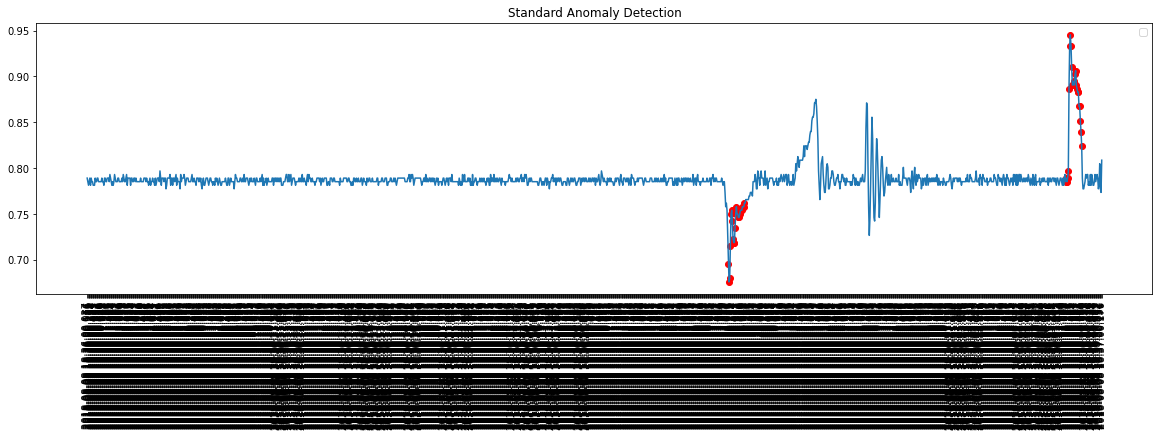

In [0]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
target_pd.sort_values(by=['timestamp'],inplace=True)
plt.plot(target_pd['timestamp'],target_pd['Z'],'-')
plt.scatter(target_pd.timestamp[target_pd.anomaly==True], target_pd.Z[target_pd.anomaly==True],marker='o',c='red')
plt.title('Standard Anomaly Detection')
plt.xticks(rotation = 90)
plt.legend();

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
y_true = reference['Anomaly']    # the true anomaly column(0/1)
y_pred = target_pd['anomaly']    # the predicted anomaly column

In [0]:
# Find the confusion matrix
tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()

In [0]:
print("True negatives :",tn)
print("False positives :",fp)
print("True positives :",fn)
print("False negatives :",tp)

True negatives : 1435
False positives : 36
True positives : 35
False negatives : 14


In [0]:
# Calculate precision and recall

precision = tp/(tp + fp)
recall = tp/(tp + fn) 

In [0]:
precision

0.28

In [0]:
recall

0.2857142857142857

In [0]:
f1_score = (2*(precision * recall))/(precision + recall)

In [0]:
f1_score

0.2828282828282828